# Install Library and GPU checking

In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install opendatasets
!pip install albumentations==0.4.6
!pip install torch-summary

In [ ]:
!nvidia-smi

Sat Feb 12 09:42:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Library

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

# Configuration

In [ ]:
# config
LEARNING_RATE = 1e-4
SPLIT=0.1           # 90% for training and 10% for validation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device = {DEVICE}")
BATCH_SIZE = 4
EPOCHS = 10
NUM_WORKERS = 4     # 4 * num_gpus = 4 * 1 
IMAGE_HEIGHT = 572  # resize height
IMAGE_WIDTH = 572   # resize width
PIN_MEMORY = True   # pin memory
DATAPATH = "/content/Dataset"
TRAIN_IMG_DIR = '/content/Dataset/train'
TRAIN_MASK_DIR = '/content/Dataset/train_masks'

Using device = cuda


# Dataset

## Download Carvana dataset from kaggle

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/c/carvana-image-masking-challenge/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: doanthong
Your Kaggle Key: ··········


100%|██████████| 24.4G/24.4G [02:48<00:00, 156MB/s] 



Extracting archive ./carvana-image-masking-challenge/carvana-image-masking-challenge.zip to ./carvana-image-masking-challenge


## Unzip dataset

In [ ]:
import zipfile
# 'test.zip'
dirs = ['train.zip','train_masks.zip']
for x in dirs:
    with zipfile.ZipFile("/content/carvana-image-masking-challenge/"+ x,'r') as z:
        z.extractall("Dataset/")

In [ ]:
cd /content/Dataset

/content/Dataset


In [ ]:
!ls

train  train_masks


## Dataset Info

In [ ]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

----------Image----------
Number of images: 5088
Image shape: (1280, 1918, 3)


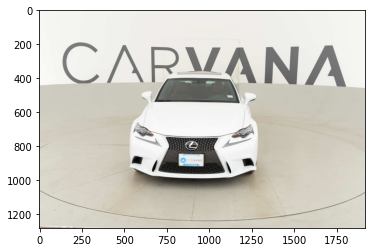


----------Mask-----------
Number of images: 5088
Mask shape: (1280, 1918)


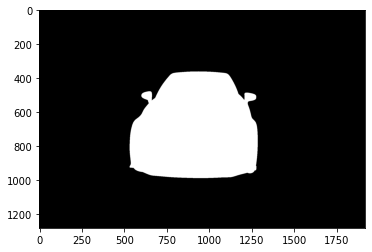

In [ ]:
print("----------Image----------")
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[100]).convert("RGB"))
print(f'Number of images: {len(images)}')
print('Image shape:', img.shape)
plt.imshow(img)
plt.show()

print("\n----------Mask-----------")
msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[100].replace(".jpg","_mask.gif")).convert("L")) # conver to gray image
print(f'Number of images: {len(masks)}')
print("Mask shape:", msk.shape)
plt.imshow(msk,cmap="gray")

plt.show()

## Make custom dataset

In [ ]:
class CarvanaDataset(Dataset):
    def __init__(self, images, image_dir, mask_dir, transforms=None, train=True):
        self.images = images
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.isTrain = train
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace('.jpg', '_mask.gif'))
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        mask[mask == 255.0] = 1

        if self.transforms is not None:
            augmentations = self.transforms(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return {"image": image,
                "mask": mask} 

## Transforms

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
train_tfs = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

valid_tfs = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

## Data and DataLoader

In [ ]:
def split_data(images, split_size):
    images_len = len(images)
    valid_len = int(images_len * split_size)
    train_len = images_len - valid_len
    train_images,val_images = images[:train_len],images[train_len:]
    
    print(f"Split {train_len} images for training and {valid_len} images to validation")
    return train_images, val_images

In [ ]:
train_images_path, val_images_path = split_data(images,SPLIT)
train_data = CarvanaDataset(train_images_path, TRAIN_IMG_DIR, TRAIN_MASK_DIR, transforms=train_tfs)
valid_data = CarvanaDataset(val_images_path, TRAIN_IMG_DIR, TRAIN_MASK_DIR, transforms=valid_tfs)

train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY)

valid_loader = DataLoader(valid_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY)

Split 4580 images for training and 508 images to validation


# Model

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => BN => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.GELU()
        )
        
    def forward(self, x):
        return self.double_conv(x)
    

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.maxpool_conv(x)
    

class Up(nn.Module):
    """Upscaling then double conv"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolution to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class Unet(nn.Module):
    
    def __init__(self, n_channels=3, n_classes=10, bilinear=True):
        super(Unet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits

# Trainer

In [ ]:
def fit(model, dataloader, data, optimizer, criterion, device='cpu'):
    model = model.to(device)    # convert model to device
    print("\nTRAINING MODE ---------------------")
    model.train()               # turn on mode train
    train_running_loss = 0.0    # sum of loss
    counter = 0

    # number of batches
    num_batches = int(len(data) / dataloader.batch_size)
    for idx, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, mask = data['image'].to(device), data['mask'].to(device) # get data and mask

        # forward
        outputs = model(image)  # [batch_size, num_classes, H, W]
        outputs = outputs.squeeze(dim=1)    # remove num_classes dimension in outputs
        loss = criterion(outputs, mask)     # compute loss
        train_running_loss += loss.item()   # total loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # optimizer
        optimizer.step()

    train_loss = train_running_loss/counter
    return train_loss

In [ ]:
def validation(model, dataloader, data, criterion, device='cpu'):
    model = model.to(device)    # convert model to device
    print("\nVALIDATION MODE --------------------")
    model.eval()               # turn on mode train
    valid_running_loss = 0.0    # sum of loss
    counter = 0

    # number of batches
    num_batches = int(len(data) / dataloader.batch_size)
    with torch.no_grad():
        for idx, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, mask = data['image'].to(device), data['mask'].to(device) # get data and mask

            # forward
            outputs = model(image)  # [batch_size, num_classes, H, W]
            outputs = outputs.squeeze(dim=1)    # remove num_classes dimension in outputs
            loss = criterion(outputs, mask)     # compute loss
            valid_running_loss += loss.item()   # total loss

    valid_loss = valid_running_loss/counter
    return valid_loss

# Run Training

In [ ]:
model = Unet(n_channels=3, n_classes=1).to(DEVICE)
from torchsummary import summary
summary(model, input_data=(3, 572, 572), device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 64, 572, 572]        --
|    └─Sequential: 2-1                   [-1, 64, 572, 572]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 572, 572]        1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 572, 572]        128
|    |    └─GELU: 3-3                    [-1, 64, 572, 572]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 572, 572]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 572, 572]        128
|    |    └─GELU: 3-6                    [-1, 64, 572, 572]        --
├─Down: 1-2                              [-1, 128, 286, 286]       --
|    └─Sequential: 2-2                   [-1, 128, 286, 286]       --
|    |    └─MaxPool2d: 3-7               [-1, 64, 286, 286]        --
|    |    └─DoubleConv: 3-8              [-1, 128, 286, 286]       221,952
├─Down: 1-3                              [-1, 256, 143, 143]       --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 64, 572, 572]        --
|    └─Sequential: 2-1                   [-1, 64, 572, 572]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 572, 572]        1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 572, 572]        128
|    |    └─GELU: 3-3                    [-1, 64, 572, 572]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 572, 572]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 572, 572]        128
|    |    └─GELU: 3-6                    [-1, 64, 572, 572]        --
├─Down: 1-2                              [-1, 128, 286, 286]       --
|    └─Sequential: 2-2                   [-1, 128, 286, 286]       --
|    |    └─MaxPool2d: 3-7               [-1, 64, 286, 286]        --
|    |    └─DoubleConv: 3-8              [-1, 128, 286, 286]       221,952
├─Down: 1-3                              [-1, 256, 143, 143]       --
|

In [ ]:
optimizer = optim.AdamW(model.parameters(),lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8], gamma=0.1)

train_loss_his = []
valid_loss_his = []
best_valid_loss = float('inf')

Epoch 1 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:05<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.68it/s]



Train loss: 0.1119
Valid loss: 0.0373

Save checkpoint ...

Epoch 2 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:05<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.69it/s]



Train loss: 0.0302
Valid loss: 0.0175

Save checkpoint ...

Epoch 3 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:04<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.68it/s]



Train loss: 0.0174
Valid loss: 0.0125

Save checkpoint ...

Epoch 4 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:04<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.67it/s]



Train loss: 0.0119
Valid loss: 0.0085

Save checkpoint ...

Epoch 5 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:04<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.67it/s]



Train loss: 0.0090
Valid loss: 0.0078

Save checkpoint ...

Epoch 6 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:04<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.67it/s]



Train loss: 0.0086
Valid loss: 0.0077

Save checkpoint ...

Epoch 7 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:04<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.69it/s]



Train loss: 0.0083
Valid loss: 0.0074

Save checkpoint ...

Epoch 8 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:04<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.69it/s]



Train loss: 0.0080
Valid loss: 0.0069

Save checkpoint ...

Epoch 9 of 10

TRAINING MODE ---------------------


100%|██████████| 1145/1145 [12:03<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.67it/s]


Train loss: 0.0077
Valid loss: 0.0069

Epoch 10 of 10

TRAINING MODE ---------------------



100%|██████████| 1145/1145 [12:03<00:00,  1.58it/s]


VALIDATION MODE --------------------



100%|██████████| 127/127 [00:22<00:00,  5.68it/s]



Train loss: 0.0076
Valid loss: 0.0070



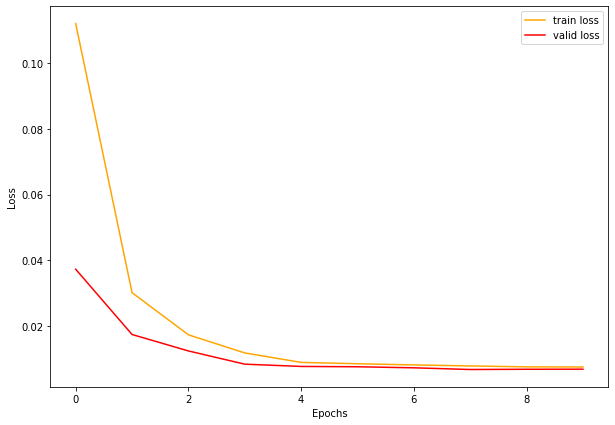


---------DONE TRAINING----------



In [21]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} of {EPOCHS}')
    train_loss = fit(model, train_loader, train_data, optimizer, criterion, DEVICE)
    valid_loss = validation(model, valid_loader, valid_data, criterion, DEVICE)
    train_loss_his.append(train_loss)
    valid_loss_his.append(valid_loss)

    print(f"\nTrain loss: {train_loss:.4f}")
    print(f"Valid loss: {valid_loss:.4f}\n")
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        checkpoint = {
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }
        torch.save(checkpoint, "./model.pth")
        print("Save checkpoint ...\n")

    scheduler1.step()
    scheduler2.step()

# loss plot
plt.figure(figsize=(10, 7))
plt.plot(train_loss_his, color="orange", label='train loss')
plt.plot(valid_loss_his, color="red", label='valid loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("\n---------DONE TRAINING----------\n")

# Inference

torch.Size([572, 572])


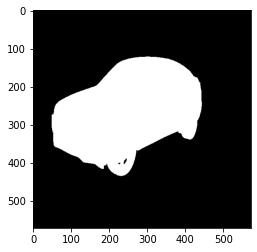

In [26]:
data = valid_data.__getitem__(169)
plt.imshow(data['mask'],cmap="gray")
print(valid_data.__getitem__(0)['mask'].shape)

torch.Size([3, 572, 572])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([572, 572])


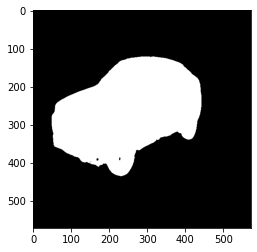

In [27]:
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")
plt.show()